# Perceptron

Deep learning is vaugely inspired by biology, and this is seen in one of the percursors to neural networks the perceptron. The perceptron takes a series of inputs, adds them together and then passes them through as step function.

![perecptron](https://i.stack.imgur.com/IjJT0.png)


The step functions is very simple it outputs 0 if n is bellow 0 and 1 if n is greater than.

$$  H[n]=\begin{cases} 0, & n < 0, \\ 1, & n \ge 0, \end{cases}   $$


This is analogous to a biological neurone which takes inputs from surrounding nerve cells in the form of neurotramsmiters, if it recieves enought inputs then it will pass a threshold point and fire an activation potential.
In the above diagram you may notice that one of the inputs is 1, this is called the bias neurone and it always inputs one.

We can create a simple perceptron in code using numpy. By taking the dot product between $x $ and $ w $ and then applying a activation function to the output. 

In [1]:
import numpy as np

In [2]:
def step_function(n):
    if n > 0:
        return 1
    return 0


In [3]:
def perceptron(w,b,x):
    return step_function(np.dot(x,w) + b)

For simlicitys sake we'll just add the bias as a number rather than maintaining a seperate $ w_0 $ weight for it. 

In [4]:
w = [1,2]
x = [1,3]
b = 1
perceptron(w,b,x)

1

Whats intresting is that the perceptron can be use to simulate boolean logic if we pick the weight rights.

In [5]:
def test_gate(w,b):
    
    X = [
        [1,1],
        [0,1],
        [1,0],
        [0,0]
    ]
    
    if len(w) == 1:
        X = [
            [1],
            [0],
        ]
    
    for x in X:
        print(" ".join((str(i) for i in x)),"| ",end="")
        output = perceptron(w,b,x)
        print(output)


In [6]:
#Not
w = [-1]
b = [1]
test_gate(w,b)

1 | 0
0 | 1


In [69]:
#And
w = [1,1.1]
b = [-2]
test_gate(w,b)

1 1 | 1
0 1 | 0
1 0 | 0
0 0 | 0


In [73]:
#Or
w = [0.6,0.6]
b = -0.5
test_gate(w,b)

1 1 | 1
0 1 | 1
1 0 | 1
0 0 | 0


You may have noticed the similarity with linear regressions, and in fact the perceptron is a simple linear classifier. It tries to seperate the data by drawing a line, and then assigns a class depending what side of the line the data falls on. This is also why XOR is not possible with a single perceptron, since the XOR problem is not linearly seperatble.


$$ y = \beta_0 + \beta_1 x $$

However if we used two perceptrons we would be able to solve the XOR problem. So far we've discovered that perceptrons can simulate boolean logic and by linking multiple perceptrons together allows us to model more complex things.

# Multi Layer Perceptron

The multilayer perceptron is a network composed of multiple perceptrons linked together. 

<img src="http://www.mdpi.com/information/information-03-00756/article_deploy/html/images/information-03-00756-g002.png" width="600">

We could implement this in numpy and there is a [great series](https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU) that does exactly that, however we'll go the easier route and use keras.

# Data

Keras comes with many common datasets built in, lets load the popular mnist dataset, which contains images of hand written digits. MNSIT is like the iris of deep learning.

In [20]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

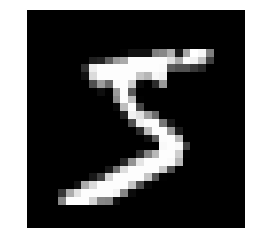

In [21]:
plt.imshow(train_images[0,:,:],cmap="gray")
plt.axis('off');

The train data

In [22]:
train_images.shape #60000 examples , 28 x 28 img dimensions

(60000, 28, 28)

In [23]:
np.unique(train_labels) # labels go from 0 to 9

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [24]:
train_labels.shape # one label for each training example

(60000,)

In [25]:
test_images.shape

(10000, 28, 28)

In [107]:
test_labels.shape

(10000,)

Before we can feed our images into the network we have 3 steps:

* Flatten the images - since the network will be a MLP (multilayer perceptron) the input must be a vector
* Change data type to float32 - since most GPU support best float32.
* Scale image values between 0 to 1, although not stricty needed up normalization speeds training times.


In [26]:
train_images = train_images.reshape(60000,-1) #flatten images
train_images = train_images.astype('float32') / 255 #change data type and scale 

test_images = test_images.reshape(10000,-1)
test_images = test_images.astype('float32') / 255

In [27]:
train_images.shape # number of images, flattened dimensions 28 * 28

(60000, 784)

In [28]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Next we need to prepare the labels by onehot encoding them.

In [29]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [32]:
train_labels.shape #number of labels, size of the onehot vector

(60000, 10)

# Network Architecture

The network will be a MLP with 3 layers. We'll use the relu activation fucntion on each layer execpt the last. On the last layer we'll use softmax since we want output to sum to 1. This way we can interpret each value in the output vector as the probablity that the digit is of that class.

In [34]:
from keras import Sequential
from keras.layers import Dense

In [42]:
network = Sequential()
network.add(Dense(256, activation='relu', input_shape=(28 * 28,))) #for first layer needs input shape
network.add(Dense(256, activation='relu'))  #other layers input shape wil be calculated for us
network.add(Dense(10, activation='softmax')) #since it's classfication final output is softmax
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


# Compilation

Before we are ready to compile and train the network we need 3 more things.

* Loss function - A function to measure how well the network is perofrming
* Optimizer - Looks at the loss functions output and updates the network acordningly to make it perform better
* Metrics to monitor traning - Well use accuracy so we can see how the network is improving during training. 

You may be wondering which optimizer to use, since there are so many different ones, as a default adam is a good choice. For the details of why see [here](http://ruder.io/optimizing-gradient-descent/).

In [49]:
network.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

We're now ready to train our network

In [50]:
history = network.fit(train_images,train_labels,epochs=10,batch_size=128,validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 1s 29us/step - loss: 0.0094 - acc: 0.9968 - val_loss: 0.0252 - val_acc: 0.9925
Epoch 2/10
48000/48000 [==============================] - 1s 20us/step - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0311 - val_acc: 0.9912
Epoch 3/10
48000/48000 [==============================] - 1s 24us/step - loss: 0.0097 - acc: 0.9966 - val_loss: 0.0417 - val_acc: 0.9891
Epoch 4/10
48000/48000 [==============================] - 1s 21us/step - loss: 0.0092 - acc: 0.9969 - val_loss: 0.0381 - val_acc: 0.9898
Epoch 5/10
48000/48000 [==============================] - 1s 22us/step - loss: 0.0051 - acc: 0.9983 - val_loss: 0.0280 - val_acc: 0.9923
Epoch 6/10
48000/48000 [==============================] - 1s 22us/step - loss: 0.0048 - acc: 0.9984 - val_loss: 0.0418 - val_acc: 0.9888
Epoch 7/10
48000/48000 [==============================] - 1s 22us/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0438 - val_acc

In [51]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

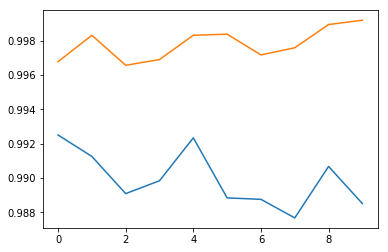

In [52]:
plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])

# Evaluation

Lets evaluate the network to see how well it does on unseen data.

In [53]:
test_loss, test_acc = network.evaluate(test_images,test_labels)
print('Test Accuracy: ',test_acc)

10000/10000 [==============================] - 0s 27us/step
Test Accuracy:  0.9805


As excpected the testing accuracy is slightly lower than the train accuracy. Now that we've created a model, we might ask ourselves how if it's possible can be improve it. Our goal is to develope a model that is able to generalize well from the training data, allowing us to make better predictions on data that we have not already seen. We must strike the balance between over fitting and underfitting, this will lead to a model that generalizes well. A simple technique is to push right up until the point of overfitting  by adding:

* More layers
* Bigger layers
* Train for longer

Once we have an understanding of this boundary we can dial it slightly back. We now have a model that has decent balance. To prevent overfitting we can add some regularization techniques, such as dropout or L2 regularization.